Stock Price Predictor
by Vedant Kamtikar

In [1]:
#Stock price predictor

In [2]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('fivethirtyeight')


In [3]:

#start = datetime.datetime(2020, 7, 31)
#end = datetime.datetime(2025, 7, 31)
# stock = input("Enter stock name: ")
df = yf.download('MSFT', start='2010-1-1', end='2025-8-15') #fetching from the internet
df
df.columns

/tmp/ipython-input-263829310.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('MSFT', start='2010-1-1', end='2025-8-15') #fetching from the internet
[*********************100%***********************]  1 of 1 completed


MultiIndex([( 'Close', 'MSFT'),
            (  'High', 'MSFT'),
            (   'Low', 'MSFT'),
            (  'Open', 'MSFT'),
            ('Volume', 'MSFT')],
           names=['Price', 'Ticker'])

In [4]:
# Number of rows and columns
df.shape

(3928, 5)

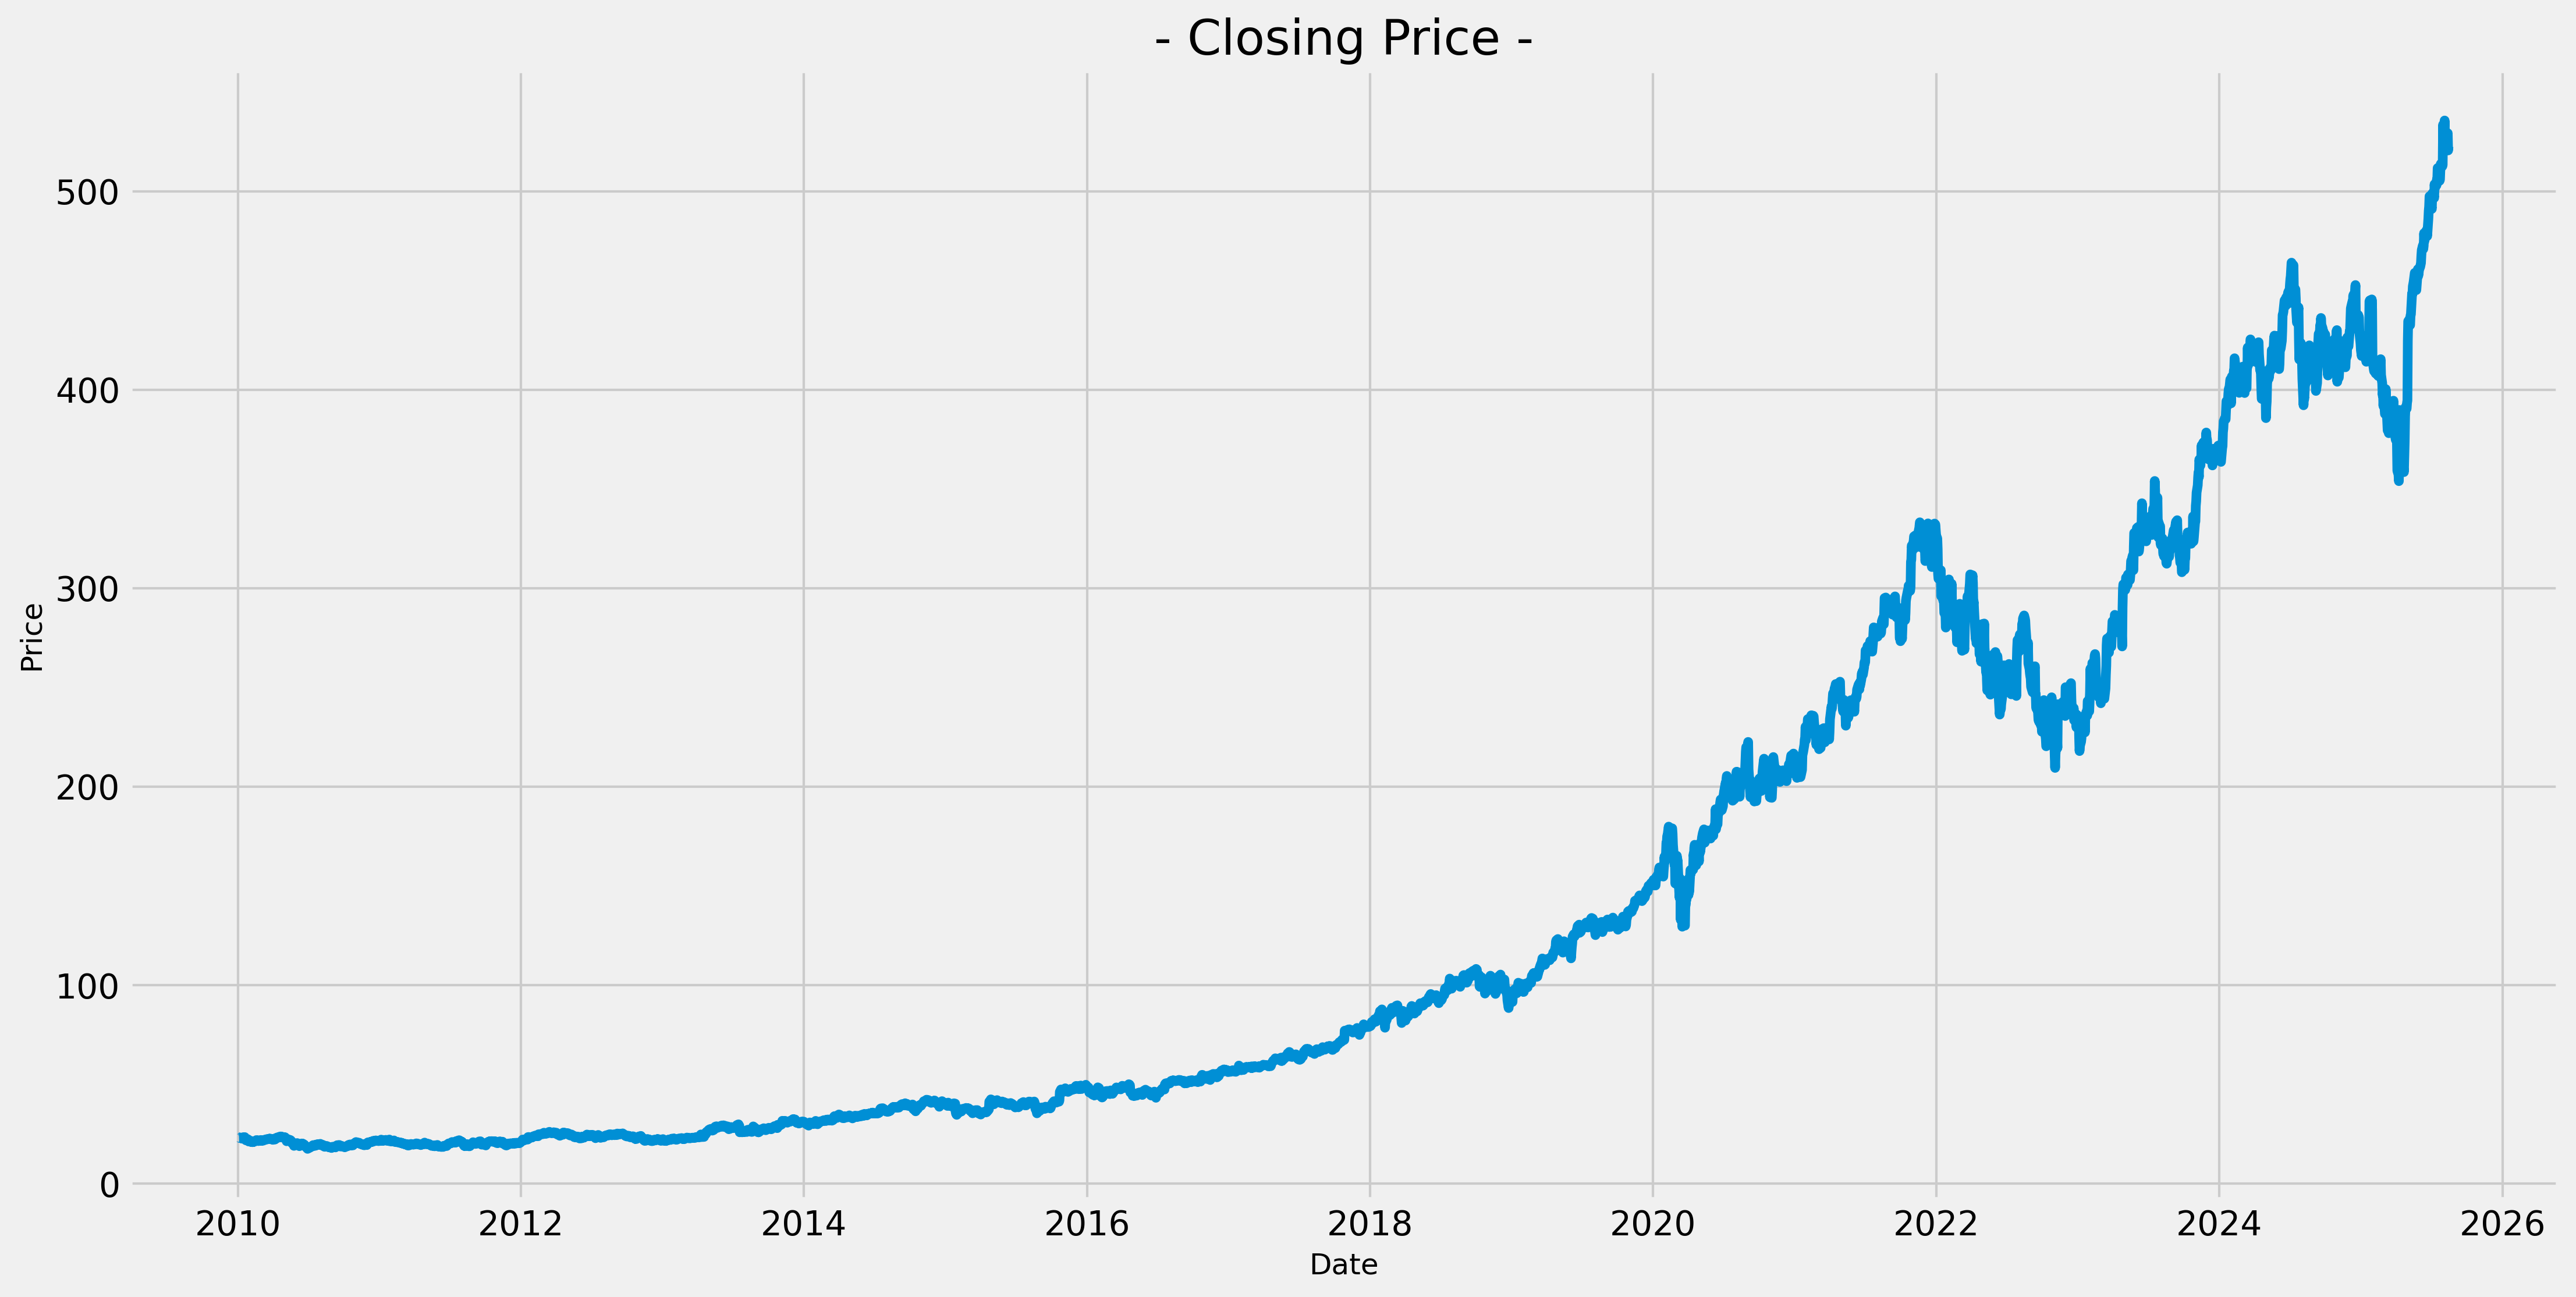

In [5]:
# Plotting the data we recieved onto a graph
plt.figure(figsize=(16,8),dpi=300)
plt.title(" - Closing Price - ")
plt.plot(df['Close'])
plt.xlabel('Date',fontsize = 12)
plt.ylabel('Price',fontsize = 12)
plt.show()

In [6]:
df.shape


(3928, 5)

In [7]:
# access the Close price for AAPL
data = df[[('Close', 'MSFT')]]
print(f"Data shape: {data.shape}")

dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.80)

# split the data into training and test
train_data = dataset[0:training_data_len, :]

# create a scaler and FIT it ONLY on the training data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data)

x_training = []
y_training = []

for i in range(60, len(scaled_train_data)):
    x_training.append(scaled_train_data[i-60:i, 0])
    y_training.append(scaled_train_data[i, 0])

# convert and reshape for the LSTM model
x_training, y_training = np.array(x_training), np.array(y_training)
x_training = np.reshape(x_training, (x_training.shape[0], x_training.shape[1], 1))

print(f"x_training shape: {x_training.shape}")
print(f"y_training shape: {y_training.shape}")

Data shape: (3928, 1)
x_training shape: (3083, 60, 1)
y_training shape: (3083,)


In [8]:
#building lstm
model = Sequential([
    Input(shape=(x_training.shape[1], 1)),
    LSTM(100, return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
#define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',         # track validation loss
    patience=12,                 # stop after 12 epochs with no improvement
    restore_best_weights=True   # revert to best model
)

In [10]:
#proper train/validation split for time series
split_idx = int(len(x_training) * 0.8)
x_train = x_training[:split_idx]
y_train = y_training[:split_idx]
x_val = x_training[split_idx:]
y_val = y_training[split_idx:]

model.fit(
   x_train, y_train,
   validation_data=(x_val, y_val),
   epochs=50,
   batch_size=32,
   callbacks=[early_stop],
   verbose=1
)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 3.0057e-05 - val_loss: 0.0021
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 2.6154e-05 - val_loss: 0.0027
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 3.1666e-05 - val_loss: 0.0022
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 2.5703e-05 - val_loss: 0.0031
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 4.1862e-05 - val_loss: 0.0029
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 2.8089e-05 - val_loss: 0.0026
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 2.5918e-05 - val_loss: 0.0023
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 3.2297e-05 - val_loss: 0.0025
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 2.9719e-05 - val_loss: 0.0011
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 3.4775e-05 - val_loss: 0.0013
Epoch 12/50
78/78 

In [11]:
#Testing data set

# test data slice from the original unscaled dataset
test_data = dataset[training_data_len - 60: , :]
# The y_test values are the actual, unscaled prices for comparison
y_test = dataset[training_data_len:, :]

# scale the test data using the scaler that was FIT on the training data
x_test_scaled = scaler.transform(test_data) # Use ONLY transform() here

#x_test sequences from the scaled test data
x_test = []
for i in range (60, len(x_test_scaled)):
  x_test.append(x_test_scaled[i-60:i, 0])

# Convert and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [12]:
#Print the model's predictions based off of x_test dataset
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [13]:
#root mean squared

rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print("RMSE = ", rmse)
print("Accuracy = ", 100 - rmse)

RMSE =  15.230935146310143
Accuracy =  84.76906485368985


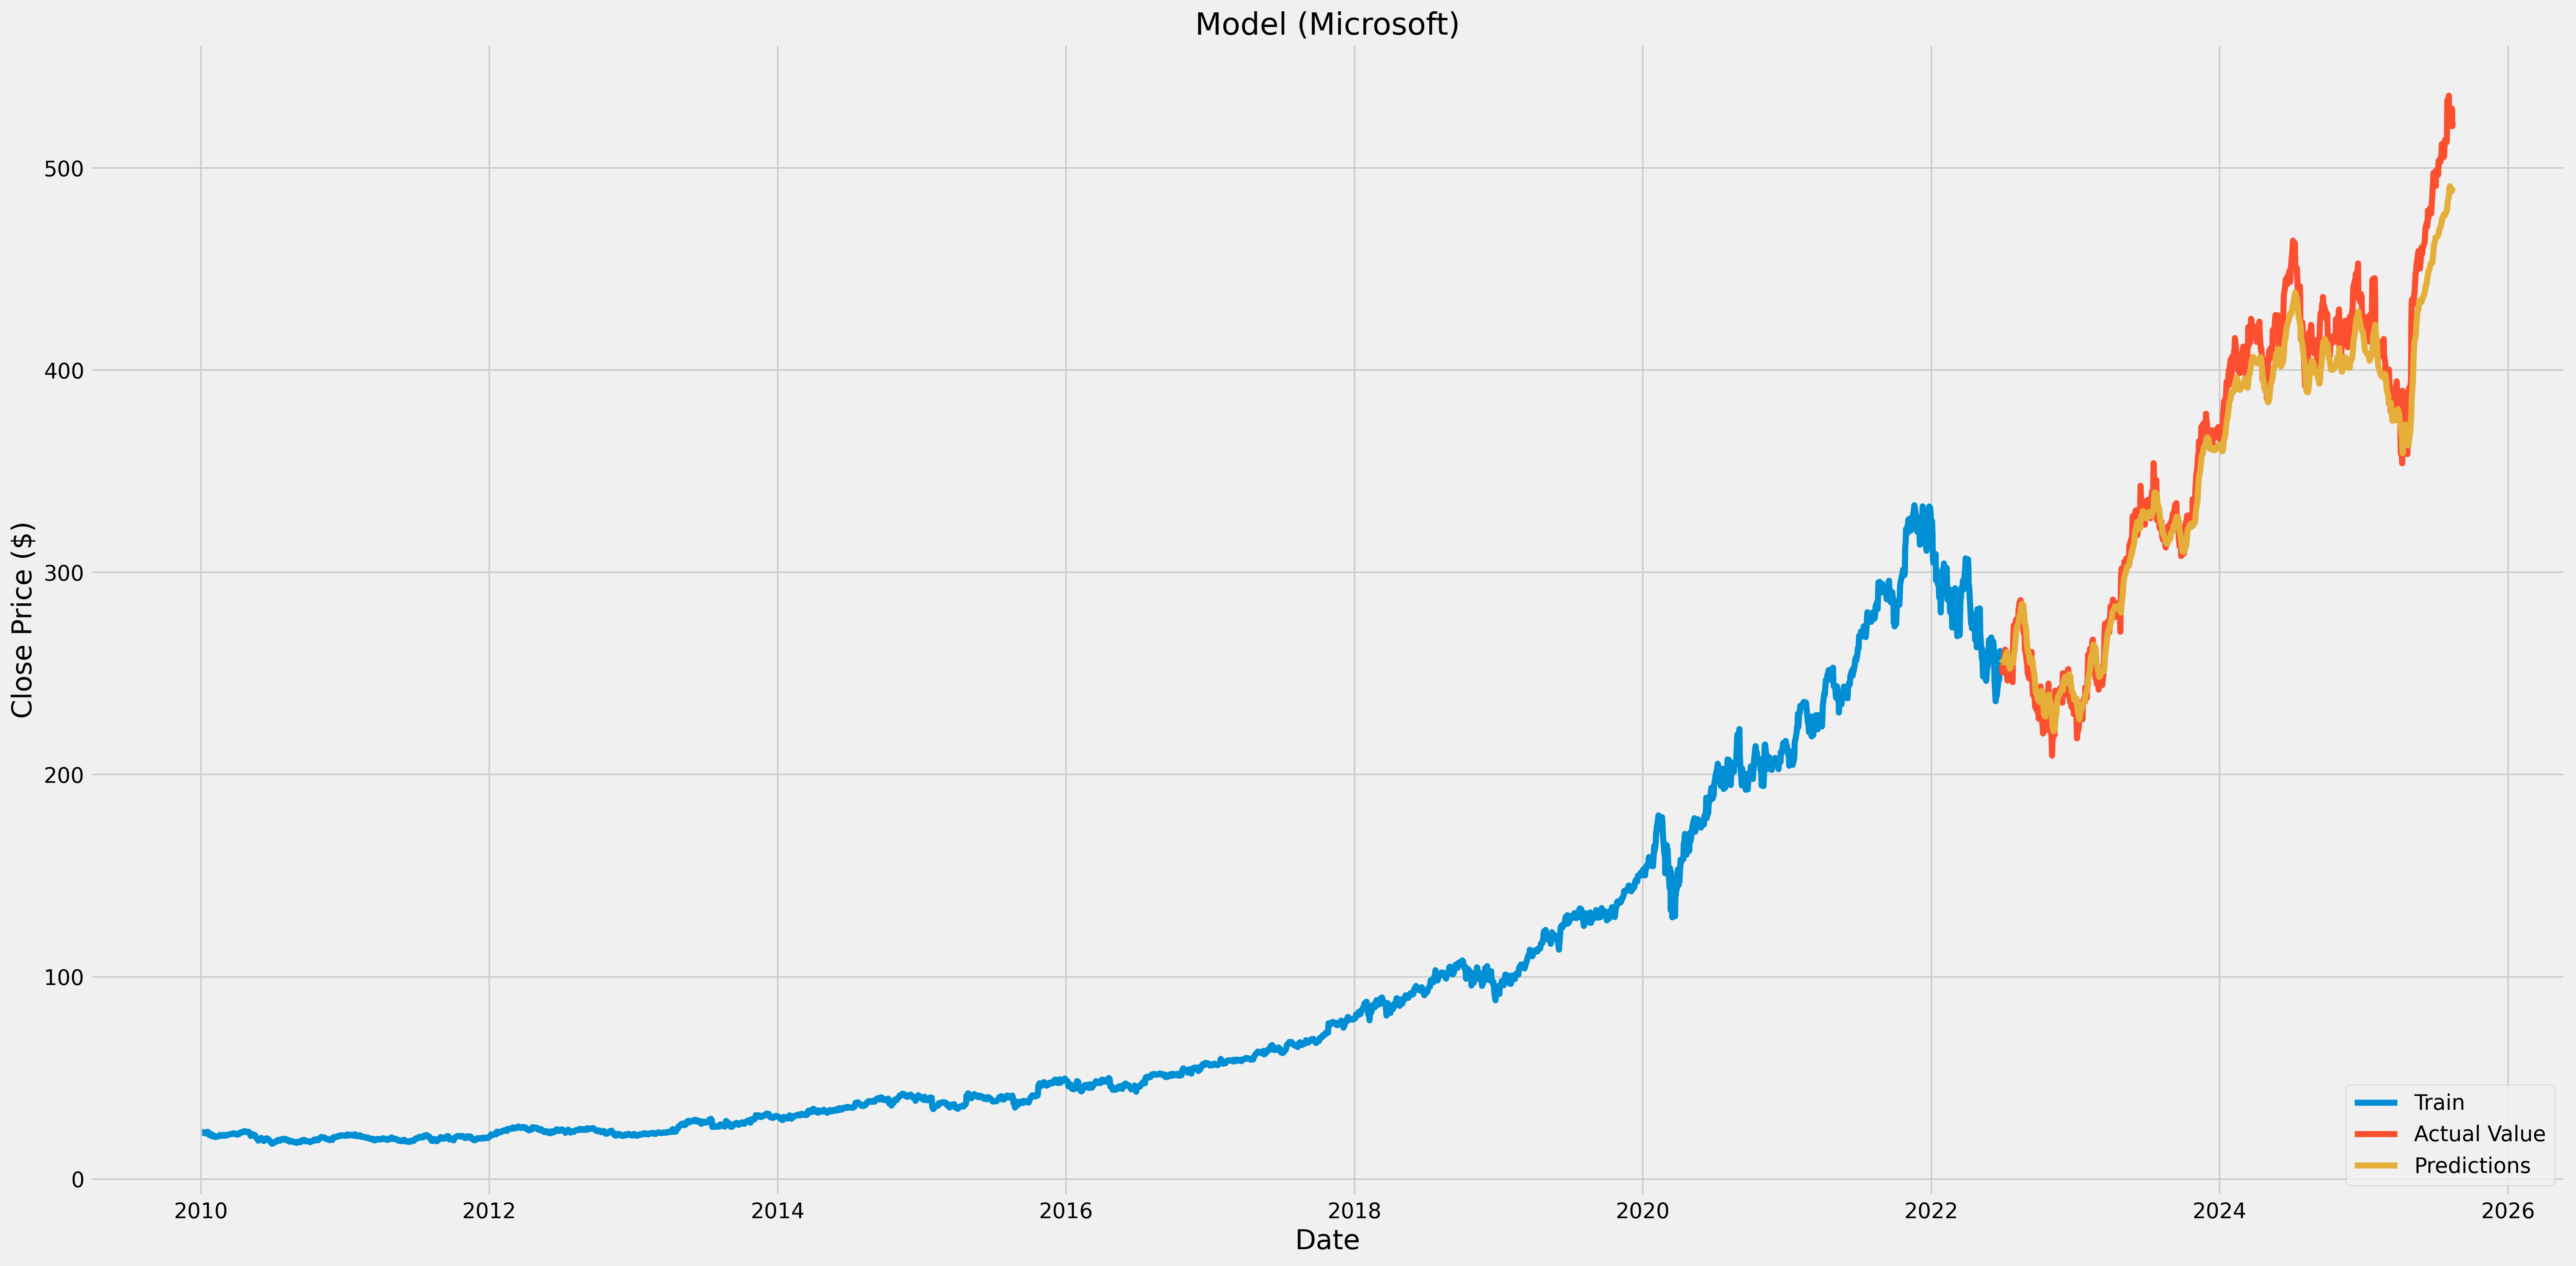

In [23]:
#training and validation sets
train = data[:training_data_len]
valid = data[training_data_len:].copy()

valid['Predictions'] = predictions


plt.figure(figsize=(26,13), dpi = 300)
plt.title('Model (Microsoft)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($)', fontsize=18)

plt.plot(train.index, train.values, label='Train')
plt.plot(valid.index, valid.iloc[:,0], label='Actual Value')
plt.plot(valid.index, valid['Predictions'], label='Predictions')

plt.legend(loc='lower right')
plt.show()


In [15]:
valid

Price,Close,Predictions
Ticker,MSFT,
Date,,
2022-06-29,253.821518,255.216904
2022-06-30,250.476379,255.850571
2022-07-01,253.158356,255.656860
2022-07-05,256.347504,255.599838
2022-07-06,259.624298,256.060425
...,...,...
2025-08-08,522.039978,490.097748
2025-08-11,521.770020,489.309753
